In [44]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

import PIL
import cv2
import pickle

(218, 178, 3)


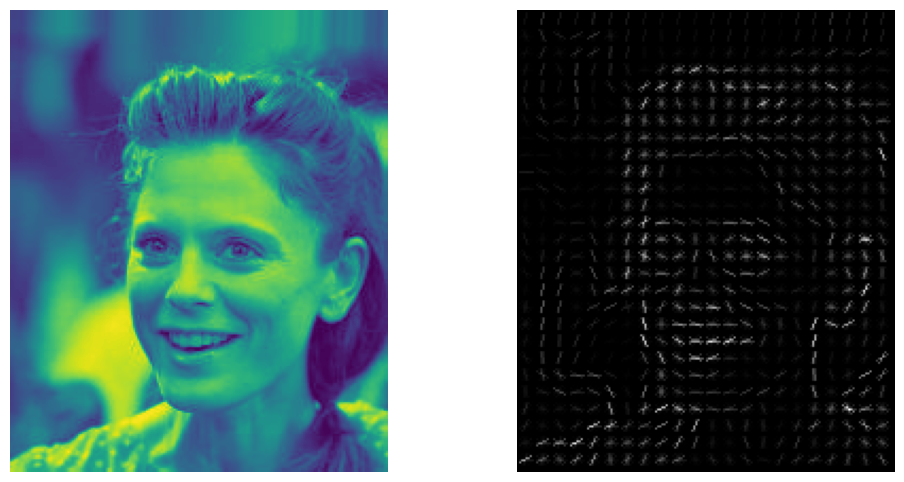

In [46]:
example_image = np.asarray(PIL.Image.open("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000002.jpg"))
print(example_image.shape)
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2GRAY)
hog_features,visualized = hog(example_image,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(2,2),
                              visualize=True)
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

In [47]:
pos_images = []
base = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
celebA_faces = os.listdir("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba")
i = 0 
for face in celebA_faces: 
        if(i>7000): break
        if ".jpg" in face:
            img = np.asarray(PIL.Image.open(base+"/"+face))
                # We don't have to use RGB channels to extract features, Grayscale is enough.
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.resize(img,(128,128))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = hog(img,orientations=9,pixels_per_cell=(8,8),
                          cells_per_block=(2,2)
                         )
                pos_images.append(img)
                i = i + 1

In [48]:
neg_images = []
negative_img = "/kaggle/input/natural-images/natural_images"
base_neg = os.listdir(negative_img)
i = 0 
# print(base_neg)
for directories in base_neg :
    base_classes = os.listdir(negative_img+"/"+directories)
    if base_classes != "person":
        for imagess in base_classes: 
                if(i>6900): break
                if ".jpg" in imagess:
                    img = np.asarray(PIL.Image.open(negative_img+"/"+directories+"/"+imagess))
                    # We don't have to use RGB channels to extract features, Grayscale is enough.
                    if len(img.shape) == 3 and img.shape[2] == 3:
                        img = cv2.resize(img,(128,128))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        img = hog(img,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(2,2)
                             )
                        neg_images.append(img)
                        i = i + 1

In [49]:
pos_labels = np.ones(len(pos_images))
neg_labels = np.zeros(len(neg_images))

In [50]:
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

In [51]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11120, 8100)
(2780, 8100)
(11120,)
(2780,)


In [52]:
svc = SVC()
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)
print("Accuracy score of model is ",accuracy_score(y_pred=y_pred,y_true=y_test)*100)

Accuracy score of model is  99.71223021582733


In [53]:
def slideExtract(image,windowSize=(128,128),channel="RGB",step=10):
    
    # Converting to grayscale
    if channel == "RGB":
        img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    elif channel == "BGR":
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    elif channel.lower()!="grayscale" or channel.lower()!="gray":
        raise Exception("Invalid channel type")
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = img[h1:h2,w1:w2]
            features_of_window = hog(window,orientations=9,pixels_per_cell=(8,8),
                                     cells_per_block=(2,2)
                                    )
            
            coords.append((w1,w2,h1,h2))
            features.append(features_of_window)
    
    return (coords,np.asarray(features))

In [54]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 10
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] 
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,40,255)
        
        return self.mask

In [55]:
def detect(image):
    
    # Extracting features and initalizing heatmap
    
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = svc.predict([features[i]])
#         print(decision)
        if decision[0] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
#     print(cont)
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 0:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        print(x,y,w,h)
        image = cv2.rectangle(image.copy(), (x, y), (x+w, y+h), (255, 0, 0), 2)  # Convert image to a writable copy

    
    return image

20 40 128 138


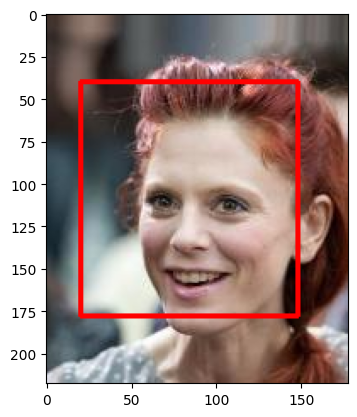

In [56]:
detected = detect(np.asarray(PIL.Image.open("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000002.jpg")))
plt.imshow(detected)

10 0 148 168


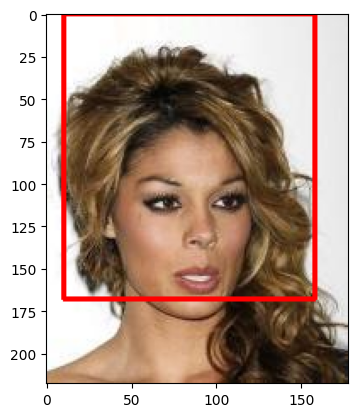

In [62]:
detected = detect(np.asarray(PIL.Image.open("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000006.jpg")))
plt.imshow(detected)

In [63]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [66]:
imagePath = '/kaggle/input/sampleset1/sample3.jpg'
img = cv2.imread(imagePath)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = face_classifier.detectMultiScale(
    gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60)
)
print("The cordinates of the formed bouding boxes are in the form (x,y,w,h)")
for (x, y, w, h) in face:
    print(x, y, w, h)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

The cordinates of the formed bouding boxes are in the form (x,y,w,h)
955 277 257 257
1513 652 68 68
503 444 249 249


(-0.5, 1599.5, 1199.5, -0.5)

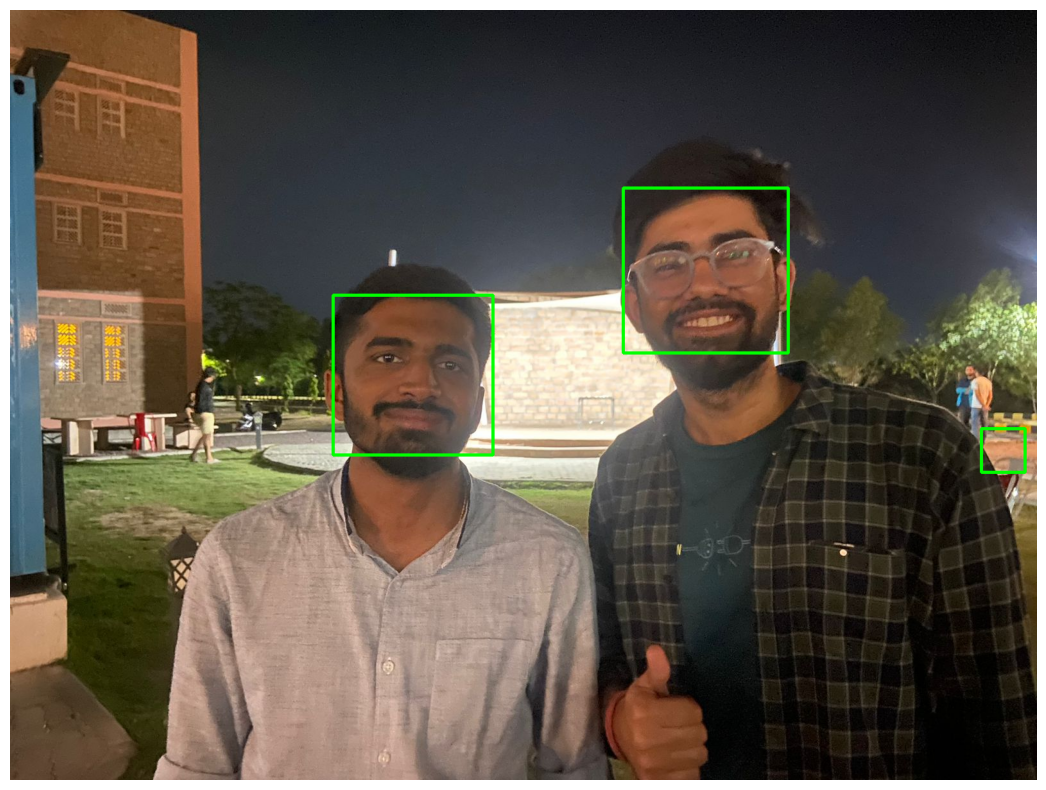

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.axis('off')

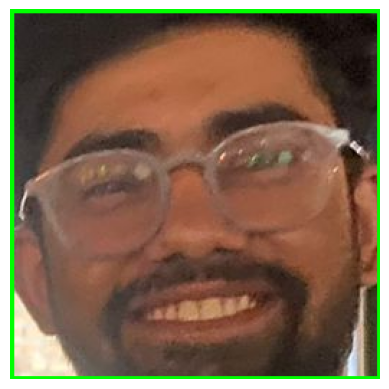

In [68]:
x, y, w, h = 955, 277, 257, 257
bounding_box_image = img[y:y+h, x:x+w]

# Show the extracted image
plt.imshow(cv2.cvtColor(bounding_box_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

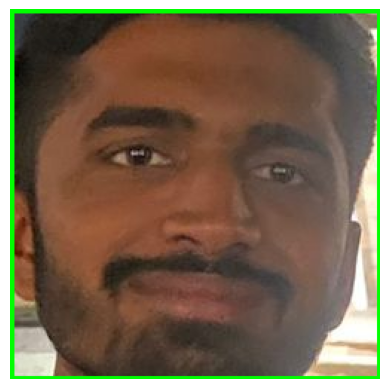

In [69]:
x, y, w, h = 503, 444, 249, 249
bounding_box_image = img[y:y+h, x:x+w]

# Show the extracted image
plt.imshow(cv2.cvtColor(bounding_box_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

677 398 200 200
222 486 261 261


(-0.5, 1279.5, 959.5, -0.5)

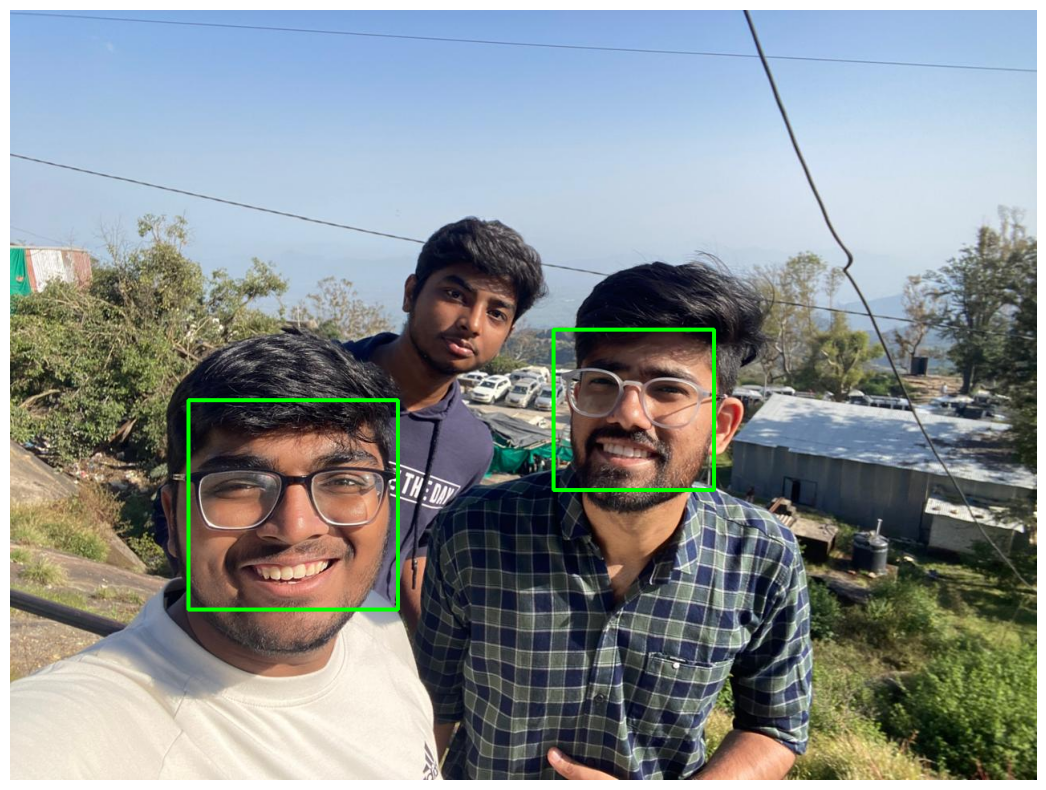

In [70]:
imagePath = '/kaggle/input/samplerr2/sampler222.jpg'
img = cv2.imread(imagePath)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = face_classifier.detectMultiScale(
    gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60)
)
for (x, y, w, h) in face:
    print(x, y, w, h)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.axis('off')

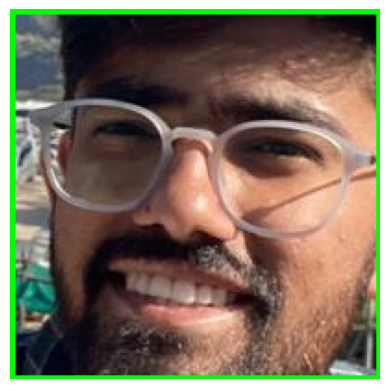

In [71]:
x, y, w, h = 677, 398, 200 ,200
bounding_box_image_2 = img[y:y+h, x:x+w]

# Show the extracted image
plt.imshow(cv2.cvtColor(bounding_box_image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

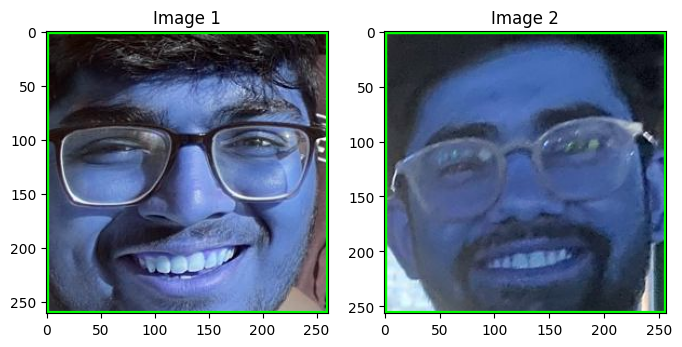

Structural Similarity Index (SSIM): 0.27284949571485306


In [99]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2

def calculate_ssim(image1, image2 ):
    # Resize images 
    image1 =  cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    min_height = min(image1.shape[0], image2.shape[0])
    min_width = min(image1.shape[1], image2.shape[1])
    image1 = cv2.resize(image1, (min_width, min_height))
    image2 = cv2.resize(image2, (min_width, min_height))

    # SSIM index
    ssim_index, _ = ssim(image1, image2,  full=True)
    return ssim_index

ssim_value = calculate_ssim(bounding_box_image_2,bounding_box_image)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(bounding_box_image_2, cmap='gray')
plt.title("Image 1")

plt.subplot(1, 2, 2)
plt.imshow(bounding_box_image, cmap='gray')
plt.title("Image 2")
plt.show()

# SSIM value
print("Structural Similarity Index (SSIM):", ssim_value)

SSIM (skimage): 0.27284949571485306
Custom SSIM: 0.923386124968117


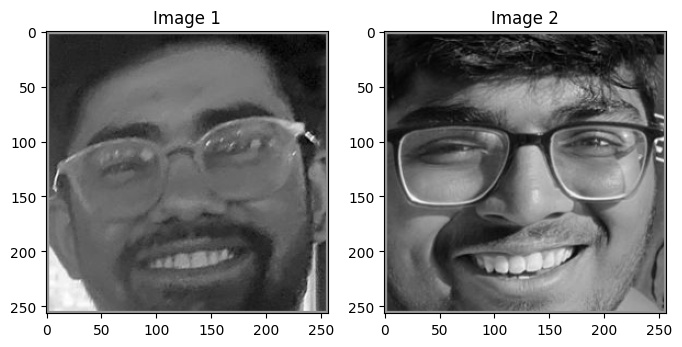

In [102]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim_skimage

# Constants
K1 = 0.01
K2 = 0.03
K3 = 0.05

def read_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image

def luminance(image):
    return np.mean(image, axis=(0, 1))

def contrast(image):
    mu = luminance(image)
    sigma2 = np.var(image, axis=(0, 1))
    return sigma2 / (mu**2 + K1)

def gaussian_filter(image, sigma=K2):
    # Gaussian filter 
    # We can use cv2.GaussianBlur
    return cv2.GaussianBlur(image, (15, 15), sigma)

def structure(image1, image2):
    filtered1 = gaussian_filter(image1)
    filtered2 = gaussian_filter(image2)
    mu1, mu2 = luminance(filtered1), luminance(filtered2)
    sigma12 = np.var(filtered1 - mu1, axis=(0, 1)) * np.var(filtered2 - mu2, axis=(0, 1))
    return sigma12 / ((np.var(filtered1, axis=(0, 1)) + np.var(filtered2, axis=(0, 1))) / 2 + K2)

def ssim_custom(image1, image2):
    L1, L2 = luminance(image1), luminance(image2)
    C1, C2 = contrast(image1), contrast(image2)
    S12 = structure(image1, image2)
    
    L = (2 * L1 * L2 + K1) / (L1**2 + L2**2 + K1)
    C = (2 * C1 * C2 + K2) / (C1**2 + C2**2 + K2)
    S = S12 / (S12 + K3)
    
    return L * C * S

im1 =bounding_box_image
im2 = bounding_box_image_2
im1 =  cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
min_height = min(im1.shape[0], im2.shape[0])
min_width = min(im1.shape[1], im2.shape[1])
im1 = cv2.resize(im1, (min_width, min_height))
im2 = cv2.resize(im2, (min_width, min_height))

# SSIM using skimage
ssim_value_skimage = ssim_skimage(im1, im2)

# custom SSIM
ssim_value_custom = ssim_custom(im1, im2)

print("SSIM (skimage):", ssim_value_skimage)
print("Custom SSIM:", ssim_value_custom)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(im1, cmap='gray')
plt.title("Image 1")

plt.subplot(1, 2, 2)
plt.imshow(im2, cmap='gray')
plt.title("Image 2")
plt.show()


Comparing and finding the SIFT score between the patches of bounding boxes between images

0
Images are not similar.


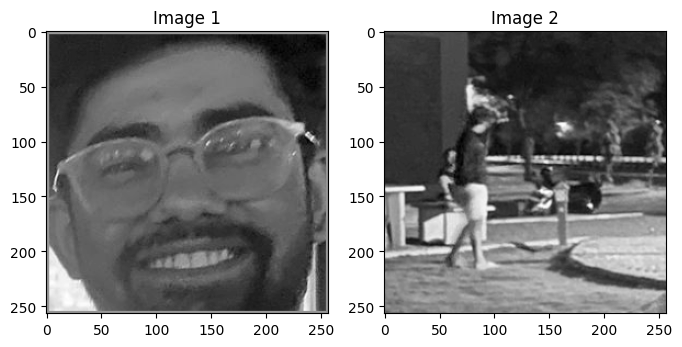

In [73]:
import cv2
import numpy as np

def image_matching(img1, img2):

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect key points and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(des1, des2, k=2)

    # ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    print(len(good_matches))   
    min_good_matches = 5 # Adjust this threshold as needed
    if len(good_matches) >= min_good_matches:
        print("Images are similar.")
    else:
        print("Images are not similar.")
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title("Image 1")

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title("Image 2")
    plt.show()

image_matching(im1,im2)

## CLUSTERING

In [77]:
import shutil



def get_clusters(similarity):
#     similarity = similarity / np.max(similarity)
    num_images = similarity.shape[0]
    clusters = {}
    image_hash = np.zeros(num_images)
    for i in range(len(image_hash)):
        if image_hash[i] == 0:
            clusters[i] = []
            image_hash[i] = 1
            for j in range(num_images):
                if (i == j or image_hash[j] == 1):
                     continue
                else :
                    if(similarity[i][j] == 1):
                        clusters[i].append(j)
                        image_hash[j] = 1
    return clusters

def image_matching(img1, img2):

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect key points and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(des1, des2, k=2)

    # ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
#     print(len(good_matches))   
    min_good_matches = 5 # Adjust this threshold as needed
    if len(good_matches) >= min_good_matches:
#         print("Images are similar.")
        return 1
    else:
#         print("Images are not similar.")
        return 0






face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
def detect_faces(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))
    face_images = []
    for i, (x, y, w, h) in enumerate(faces):
        # Crop the detected face region
        face_image = img[y:y+h, x:x+w]
        face_images.append(face_image)
#     if len(face_images) > 1:
    print(len(face_images), img_path)
    if(len(face_images) == 1):
        plt.imshow(face_images[0])
        plt.show()
    else:
        fig, ax = plt.subplots(1, len(face_images))
        for i in range(len(face_images)):
            ax[i].imshow(face_images[i])
        plt.show()
    return face_images

def generate_data(folder_path):
    index = 0
    data = []
    face_to_index = []
    all_faces = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        faces = detect_faces(image_path)
        all_faces += faces
        face_to_index += [index for _ in range(len(faces))]
        index += 1    
    
    n = len(all_faces)
    similarity = np.ones((n, n))
    for i in range(n):
        for j in range(i+1 , n):
            similarity[i][j] = image_matching(all_faces[i], all_faces[j])
            similarity[j][i] = similarity[i][j]    
    return similarity, face_to_index, all_faces

def cluster_embeddings(similarity):
#     similarity = cosine_similarity(data)
    clusters = get_clusters(similarity)
    cluster_labels = {}
    for i in clusters:
        if len(clusters[i]) == 0:
            cluster_labels[i] = -1
            continue
        else :
            cluster_labels[i] = i
            for x in clusters[i] :
                cluster_labels[x] = i
    return dict(sorted(cluster_labels.items())).values()

def map_images(folder_path):
    embeddings, face_to_index, all_faces = generate_data(folder_path)
    labels_faces = cluster_embeddings(embeddings)
    labels_images = {}
    for i, l in enumerate(labels_faces):
        parent_image = face_to_index[i]
        if parent_image in labels_images:
            labels_images[parent_image].append(l)
        else :
            labels_images[parent_image] = [l]
    
    return labels_images, labels_faces, all_faces

def copy_image(source_path, destination_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    # Extract the filename from the source path
    filename = os.path.basename(source_path)
    
    # Construct the destination path including the filename
    destination_path = os.path.join(destination_dir, filename)
    
    # Copy the image file from source to destination
    shutil.copyfile(source_path, destination_path)


def create_cluster_folder(folder_path, cluster_folder_directory):
    image_cluster, labels_faces, all_faces = map_images(folder_path)
    # image_cluster = dict(sorted(image_cluster.items()))
    print("Image clusters Created.....")
    print("Creating cluster wise folders......")
    index = 0
#     print(image_cluster)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if index in image_cluster:
            clusters = image_cluster[index]
            for c in clusters:
                destination_path = os.path.join(cluster_folder_directory, "identity_" + str(c))
                copy_image(image_path, destination_path)
        index += 1
    return image_cluster, labels_faces, all_faces

2 /kaggle/input/cv-personal/cv_dataset/vidit_5.jpg


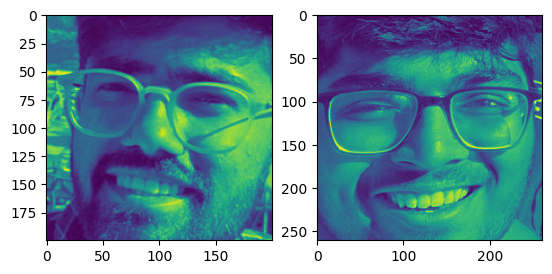

1 /kaggle/input/cv-personal/cv_dataset/vidit_3.jpg


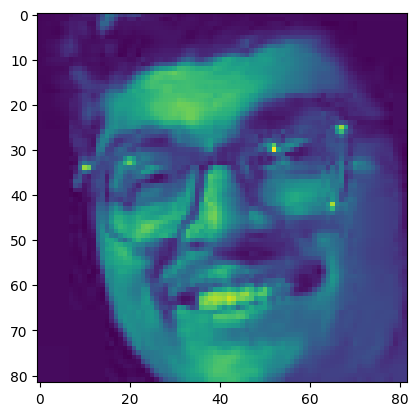

2 /kaggle/input/cv-personal/cv_dataset/vidit_7.jpg


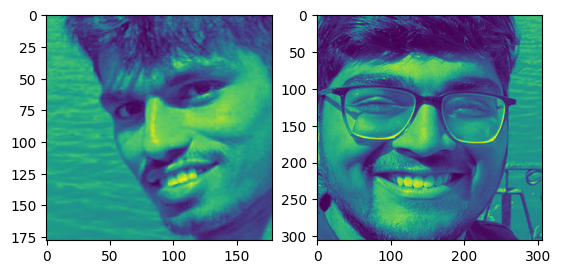

2 /kaggle/input/cv-personal/cv_dataset/vidit_1.jpg


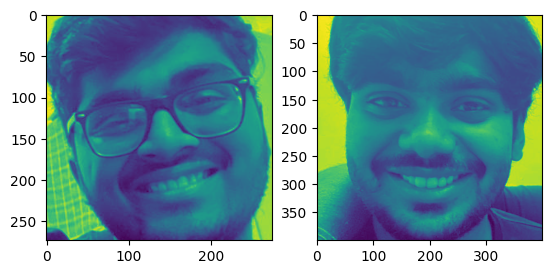

1 /kaggle/input/cv-personal/cv_dataset/keshav_2.jpg


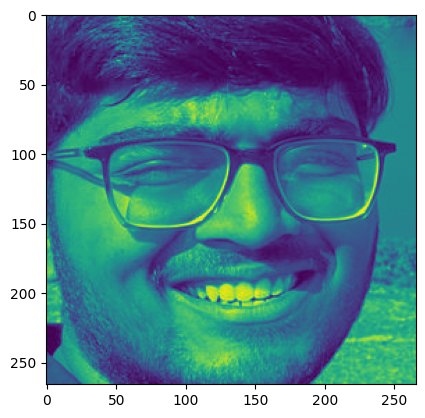

1 /kaggle/input/cv-personal/cv_dataset/vidit_6.jpg


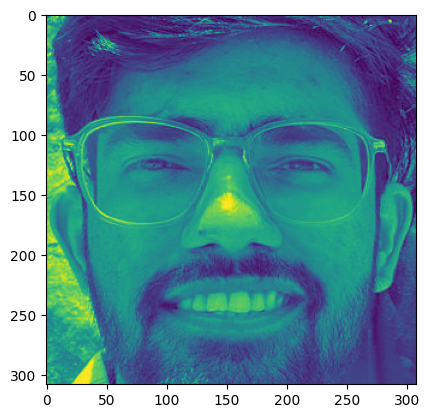

3 /kaggle/input/cv-personal/cv_dataset/vidit_4.jpg


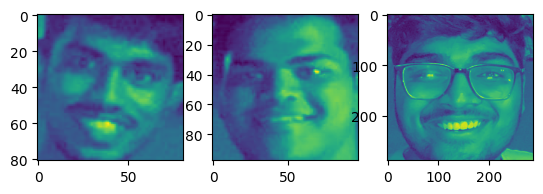

2 /kaggle/input/cv-personal/cv_dataset/keshav.jpg


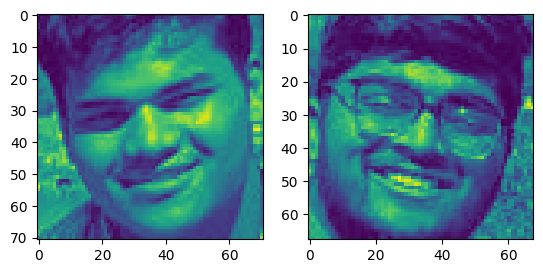

1 /kaggle/input/cv-personal/cv_dataset/vidit2.jpg


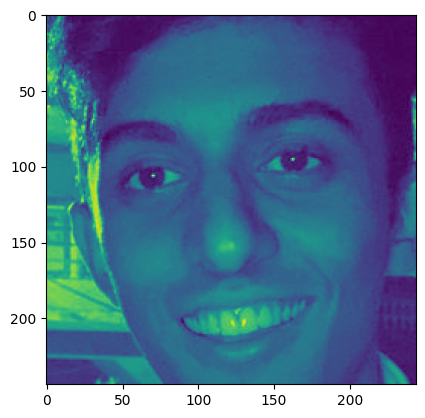

Image clusters Created.....
Creating cluster wise folders......


In [78]:
folder_path = "/kaggle/input/cv-personal/cv_dataset"
image_cluster, labels_faces, all_faces = create_cluster_folder(folder_path, "/kaggle/working/")
cluster_image = {}
for image, clusters in image_cluster.items():
    for cluster in clusters:
        if cluster in cluster_image:
            cluster_image[cluster].append(image)
        else :
            cluster_image[cluster] = [image]
        
img_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]

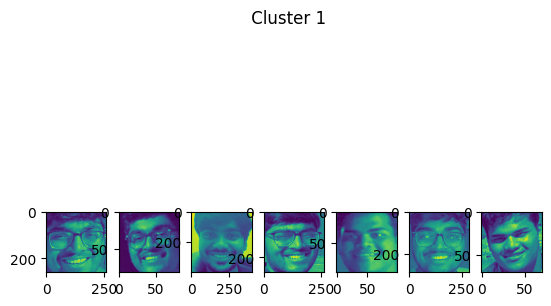

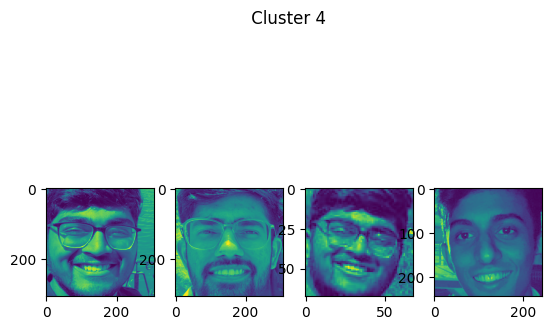

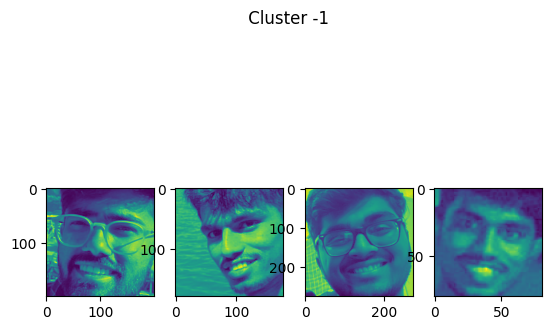

In [79]:
labels_faces = np.array(list(labels_faces))
cluster_to_face = {}
for c in set(labels_faces):
#     print(c)
    ind = np.where(labels_faces == c)[0]
    cluster_to_face[c] = ind
for c in cluster_to_face:
    ind = cluster_to_face[c]
    fig, ax = plt.subplots(1, len(ind))
    for i in range(len(ind)):
        ax[i].imshow(all_faces[ind[i]])
    fig.suptitle(f" Cluster {c}")
    plt.show()

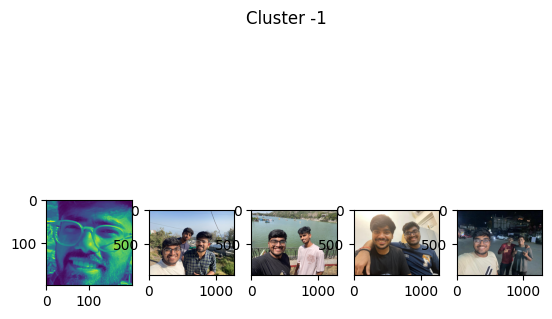

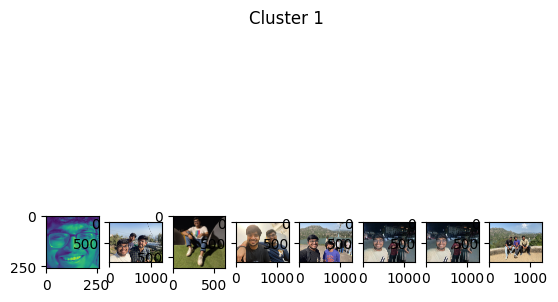

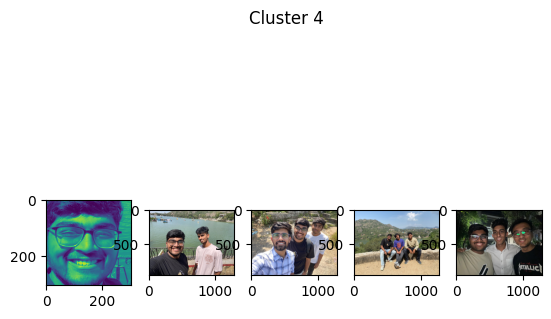

In [80]:
for i, (c, imgs) in enumerate(cluster_image.items()):
    fig, ax = plt.subplots(1, len(imgs) + 1)
    ax[0].imshow(all_faces[cluster_to_face[c][0]])
    
    for j, ind in enumerate(imgs):
        img = cv2.imread(img_paths[ind])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[j+ 1].imshow(img)
    fig.suptitle(f"Cluster {c}")
    plt.show()

## DUPLICATE IMAGE DETECTION

No Duplicates found


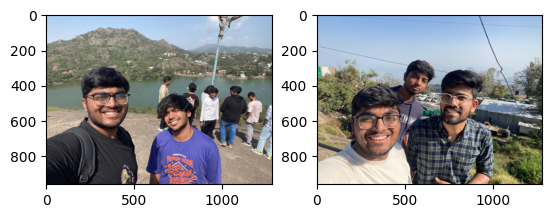

In [86]:
import imagehash
from PIL import Image

image1 = Image.open("/kaggle/working/identity_0/keshav_2.jpg")
image2 = Image.open("/kaggle/working/identity_0/vidit_5.jpg")
# Note: images DO NOT have to be of equal size

# Construct the hash
hash1 = imagehash.average_hash(image1)
hash2 = imagehash.average_hash(image2)

# Calculate the hamming distance
value = hash1-hash2
if value  == 0:
    print("Duplicate images Detected")
else:
    print("No Duplicates found")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image1)
ax[1].imshow(image2)

No Duplicates found


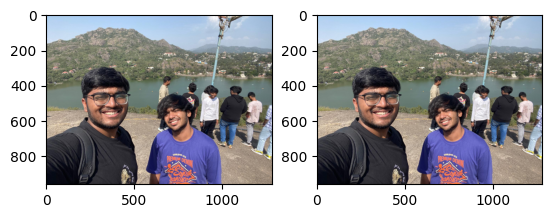

In [87]:
import imagehash
from PIL import Image

image1 = Image.open("/kaggle/working/identity_0/keshav_2.jpg")
image2 = Image.open("/kaggle/working/identity_0/keshav_2.jpg")
# Note: images DO NOT have to be of equal size

# Construct the hash
hash1 = imagehash.average_hash(image1)
hash2 = imagehash.average_hash(image2)

# Calculate the hamming distance
if value  == 0:
    print("Duplicate images Detected")
else:
    print("No Duplicates found")
    
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image1)
ax[1].imshow(image2)